In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from functools import partial
from distutils.version import LooseVersion
from einops import repeat

In [2]:
TORCH_GE_1_8_0 = LooseVersion(torch.__version__) >= LooseVersion('1.8.0')

def default(val, d):
    return val if exists(val) else d

def exists(val):
    return val is not None

def gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling = 0, device = None):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q[:remaining_rows])

    final_matrix = torch.cat(block_list)

    if scaling == 0:
        multiplier = torch.randn((nb_rows, nb_columns), device = device).norm(dim = 1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * torch.ones((nb_rows,), device = device)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return torch.diag(multiplier) @ final_matrix

def orthogonal_matrix_chunk(cols, device = None):
    unstructured_block = torch.randn((cols, cols), device = device)
    if TORCH_GE_1_8_0:
        q, r = torch.linalg.qr(unstructured_block.cpu(), mode = 'reduced')
    else:
        q, r = torch.qr(unstructured_block.cpu(), some = True)
    q, r = map(lambda t: t.to(device), (q, r))
    return q.t()

def softmax_kernel(data, *, projection_matrix, is_query, normalize_data=True, eps=1e-4, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    ratio = (projection_matrix.shape[0] ** -0.5)

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('bid,bijd->bij', (data_normalizer * data), projection)

    diag_data = data ** 2
    diag_data = torch.sum(diag_data, dim=-1)
    diag_data = (diag_data / 2.0) * (data_normalizer ** 2)
    diag_data = diag_data.unsqueeze(dim=-1)

    if is_query:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data -
                    torch.amax(data_dash, dim=-1, keepdim=True).detach()) + eps)
    else:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data - torch.amax(data_dash, dim=(-1, -2), keepdim=True).detach()) + eps)

    return data_dash.type_as(data)

def linear_attention(q, k, v):
    k_cumsum = k.sum(dim = -2)
    D_inv = 1. / torch.einsum('...nd,...d->...n', q, k_cumsum.type_as(q))
    context = torch.einsum('...nd,...ne->...de', k, v)
    out = torch.einsum('...de,...nd,...n->...ne', context, q, D_inv)
    return out

In [3]:
class FastAttention(nn.Module):
    def __init__(self, dim_heads, nb_features = None, ortho_scaling = 0, causal = False, generalized_attention = False, kernel_fn = nn.ReLU(), no_projection = False):
        super().__init__()
        nb_features = default(nb_features, int(dim_heads * math.log(dim_heads)))

        self.dim_heads = dim_heads
        self.nb_features = nb_features
        self.ortho_scaling = ortho_scaling

        self.create_projection = partial(gaussian_orthogonal_random_matrix, nb_rows = self.nb_features, nb_columns = dim_heads, scaling = ortho_scaling)
        projection_matrix = self.create_projection()
        self.register_buffer('projection_matrix', projection_matrix)

        self.generalized_attention = generalized_attention
        self.kernel_fn = kernel_fn

        # if this is turned on, no projection will be used
        # queries and keys will be softmax-ed as in the original efficient attention paper
        self.no_projection = no_projection

        self.causal = causal
        if causal:
            try:
                import fast_transformers.causal_product.causal_product_cuda
                self.causal_linear_fn = partial(causal_linear_attention)
            except ImportError:
                print('unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version')
                self.causal_linear_fn = causal_linear_attention_noncuda

    @torch.no_grad()
    def redraw_projection_matrix(self, device):
        projections = self.create_projection(device = device)
        self.projection_matrix.copy_(projections)
        del projections

    def forward(self, q, k, v):
        device = q.device

        if self.no_projection:
            q = q.softmax(dim = -1)
            k = torch.exp(k) if self.causal else k.softmax(dim = -2)

        elif self.generalized_attention:
            create_kernel = partial(generalized_kernel, kernel_fn = self.kernel_fn, projection_matrix = self.projection_matrix, device = device)
            q, k = map(create_kernel, (q, k))

        else:
            create_kernel = partial(softmax_kernel, projection_matrix = self.projection_matrix, device = device)
            q = create_kernel(q, is_query = True)
            k = create_kernel(k, is_query = False)

        attn_fn = linear_attention if not self.causal else self.causal_linear_fn
        out = attn_fn(q, k, v)
        return out

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.dec_attn = FastAttention(dim_heads=d_model, nb_features=20)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x, dec_attn_mask=None, mems=None):
               
        attention_output = self.dec_attn(x, x, x)
        x = self.layer_norm1(x + self.dropout(attention_output))
        feedforward_output = self.positionwise_feedforward(x)
        x = self.layer_norm2(x + self.dropout(feedforward_output))
        return x

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=20):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) #.transpose(0, 1)
        self.register_buffer('pe', pe)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x + self.pe.repeat(x.size(0),1,1)
        x = self.dropout(x)
        return x

In [6]:
class Performer(nn.Module):
    def __init__(self, num_layers, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.encoder_layers = nn.ModuleList([EncoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])
#        self.decoder_layers = nn.ModuleList([DecoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])

        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        
    def forward(self, input_ids):

        input_embeddings = input_ids

        # Apply positional encoding
        input_embeddings = self.positional_encoding(input_embeddings)

        # Encode inputs
        for layer in self.encoder_layers:
            input_embeddings = layer(input_embeddings)


        output=torch.mean(input_embeddings,dim=1,keepdim=False)
        output = F.relu(self.flatten(output))
        output = self.final_layer(output)
        
        return output

In [7]:
num_layers = 2
num_heads = 2
d_model = 22
d_ff = 64
dropout = 0
model = Performer(num_layers=num_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout)

input_ids = torch.rand(10,20,22)
output = model(input_ids)
print(output.shape)
print(output)

torch.Size([10, 1])
tensor([[0.1316],
        [0.1197],
        [0.2875],
        [0.0792],
        [0.2216],
        [0.1157],
        [0.1503],
        [0.2175],
        [0.1495],
        [0.1601]], grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [13]:
trainX=[]
trainY=[]

In [14]:
n_future=1
n_past=20

In [15]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [16]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [17]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [18]:
data,label=trainX,trainY

In [19]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [20]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [21]:
label=standardization(label)

In [22]:
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data,  label)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data1, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output = model(data1)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.9945341944694519
Epoch: 1 Loss: 0.8290154337882996
Epoch: 2 Loss: 0.718517005443573
Epoch: 3 Loss: 0.6587560176849365
Epoch: 4 Loss: 0.6311359405517578
Epoch: 5 Loss: 0.6902188658714294
Epoch: 6 Loss: 0.6280637979507446
Epoch: 7 Loss: 0.6035953760147095
Epoch: 8 Loss: 0.643177330493927
Epoch: 9 Loss: 0.6026811003684998
Epoch: 10 Loss: 0.6671141386032104
Epoch: 11 Loss: 0.5952019691467285
Epoch: 12 Loss: 0.6020334959030151
Epoch: 13 Loss: 0.5890995264053345
Epoch: 14 Loss: 0.602409303188324
Epoch: 15 Loss: 0.5975711345672607
Epoch: 16 Loss: 0.6100403666496277
Epoch: 17 Loss: 0.5700142979621887
Epoch: 18 Loss: 0.5662837028503418
Epoch: 19 Loss: 0.5594422221183777
Epoch: 20 Loss: 0.5944268703460693
Epoch: 21 Loss: 0.5502749681472778
Epoch: 22 Loss: 0.6348615288734436
Epoch: 23 Loss: 0.537803590297699
Epoch: 24 Loss: 0.6156390309333801
Epoch: 25 Loss: 0.5275090932846069
Epoch: 26 Loss: 0.5771358013153076
Epoch: 27 Loss: 0.5210729837417603
Epoch: 28 Loss: 0.5498416423797607

Epoch: 230 Loss: 0.3499830365180969
Epoch: 231 Loss: 0.4223804175853729
Epoch: 232 Loss: 0.3359248638153076
Epoch: 233 Loss: 0.4917910099029541
Epoch: 234 Loss: 0.3341115117073059
Epoch: 235 Loss: 0.5179794430732727
Epoch: 236 Loss: 0.33569350838661194
Epoch: 237 Loss: 0.5296145677566528
Epoch: 238 Loss: 0.34269338846206665
Epoch: 239 Loss: 0.4375273585319519
Epoch: 240 Loss: 0.35420554876327515
Epoch: 241 Loss: 0.4478954076766968
Epoch: 242 Loss: 0.37708449363708496
Epoch: 243 Loss: 0.3883543014526367
Epoch: 244 Loss: 0.3477998971939087
Epoch: 245 Loss: 0.3590804636478424
Epoch: 246 Loss: 0.4436270594596863
Epoch: 247 Loss: 0.3322276175022125
Epoch: 248 Loss: 0.48902854323387146
Epoch: 249 Loss: 0.3309987485408783
Epoch: 250 Loss: 0.6742424964904785
Epoch: 251 Loss: 0.39734140038490295
Epoch: 252 Loss: 0.39566558599472046
Epoch: 253 Loss: 0.3506241738796234
Epoch: 254 Loss: 0.4784417152404785
Epoch: 255 Loss: 0.33659082651138306
Epoch: 256 Loss: 0.43043556809425354
Epoch: 257 Loss: 0.

Epoch: 456 Loss: 0.40324971079826355
Epoch: 457 Loss: 0.36377567052841187
Epoch: 458 Loss: 0.332721471786499
Epoch: 459 Loss: 0.3833584487438202
Epoch: 460 Loss: 0.32445579767227173
Epoch: 461 Loss: 0.38297101855278015
Epoch: 462 Loss: 0.3267258405685425
Epoch: 463 Loss: 0.43986305594444275
Epoch: 464 Loss: 0.3120439052581787
Epoch: 465 Loss: 0.4548543691635132
Epoch: 466 Loss: 0.2994515895843506
Epoch: 467 Loss: 0.39102935791015625
Epoch: 468 Loss: 0.4340851902961731
Epoch: 469 Loss: 0.31411680579185486
Epoch: 470 Loss: 0.3130805492401123
Epoch: 471 Loss: 0.3284417986869812
Epoch: 472 Loss: 0.4585585296154022
Epoch: 473 Loss: 0.32822179794311523
Epoch: 474 Loss: 0.5063671469688416
Epoch: 475 Loss: 0.30438709259033203
Epoch: 476 Loss: 0.4436735510826111
Epoch: 477 Loss: 0.2949363887310028
Epoch: 478 Loss: 0.43202638626098633
Epoch: 479 Loss: 0.30079638957977295
Epoch: 480 Loss: 0.3201357126235962
Epoch: 481 Loss: 0.3753361701965332
Epoch: 482 Loss: 0.3196418881416321
Epoch: 483 Loss: 0

Epoch: 682 Loss: 0.34357601404190063
Epoch: 683 Loss: 0.2865619659423828
Epoch: 684 Loss: 0.4297131299972534
Epoch: 685 Loss: 0.27525800466537476
Epoch: 686 Loss: 0.3267756402492523
Epoch: 687 Loss: 0.2930402159690857
Epoch: 688 Loss: 0.35806480050086975
Epoch: 689 Loss: 0.40729865431785583
Epoch: 690 Loss: 0.29781290888786316
Epoch: 691 Loss: 0.31598326563835144
Epoch: 692 Loss: 0.3451381325721741
Epoch: 693 Loss: 0.3518295884132385
Epoch: 694 Loss: 0.314378559589386
Epoch: 695 Loss: 0.37524712085723877
Epoch: 696 Loss: 0.2986528277397156
Epoch: 697 Loss: 0.39643651247024536
Epoch: 698 Loss: 0.29402753710746765
Epoch: 699 Loss: 0.4547002613544464
Epoch: 700 Loss: 0.2770652174949646
Epoch: 701 Loss: 0.38352906703948975
Epoch: 702 Loss: 0.3248661458492279
Epoch: 703 Loss: 0.3208233714103699
Epoch: 704 Loss: 0.3341973125934601
Epoch: 705 Loss: 0.30883485078811646
Epoch: 706 Loss: 0.4200696349143982
Epoch: 707 Loss: 0.2811630964279175
Epoch: 708 Loss: 0.44425028562545776
Epoch: 709 Loss: 

Epoch: 908 Loss: 0.2591976821422577
Epoch: 909 Loss: 0.3750336468219757
Epoch: 910 Loss: 0.28788867592811584
Epoch: 911 Loss: 0.3545498847961426
Epoch: 912 Loss: 0.3009229600429535
Epoch: 913 Loss: 0.2941437363624573
Epoch: 914 Loss: 0.3078134059906006
Epoch: 915 Loss: 0.2967771291732788
Epoch: 916 Loss: 0.30592840909957886
Epoch: 917 Loss: 0.40107813477516174
Epoch: 918 Loss: 0.3040473461151123
Epoch: 919 Loss: 0.2791711986064911
Epoch: 920 Loss: 0.3383032977581024
Epoch: 921 Loss: 0.2610732316970825
Epoch: 922 Loss: 0.47099417448043823
Epoch: 923 Loss: 0.3659374713897705
Epoch: 924 Loss: 0.32900944352149963
Epoch: 925 Loss: 0.2801332473754883
Epoch: 926 Loss: 0.3309292197227478
Epoch: 927 Loss: 0.2674894630908966
Epoch: 928 Loss: 0.3785780370235443
Epoch: 929 Loss: 0.25139397382736206
Epoch: 930 Loss: 0.4918031394481659
Epoch: 931 Loss: 0.2869730591773987
Epoch: 932 Loss: 0.3772336542606354
Epoch: 933 Loss: 0.27582573890686035
Epoch: 934 Loss: 0.38201290369033813
Epoch: 935 Loss: 0.2

In [25]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [26]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [27]:
trainY_copy_=standardization(trainY_copy_)

In [28]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [29]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output=model(data)
    predictions+=output.tolist()

In [30]:
predictions = np.array(predictions)

In [31]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

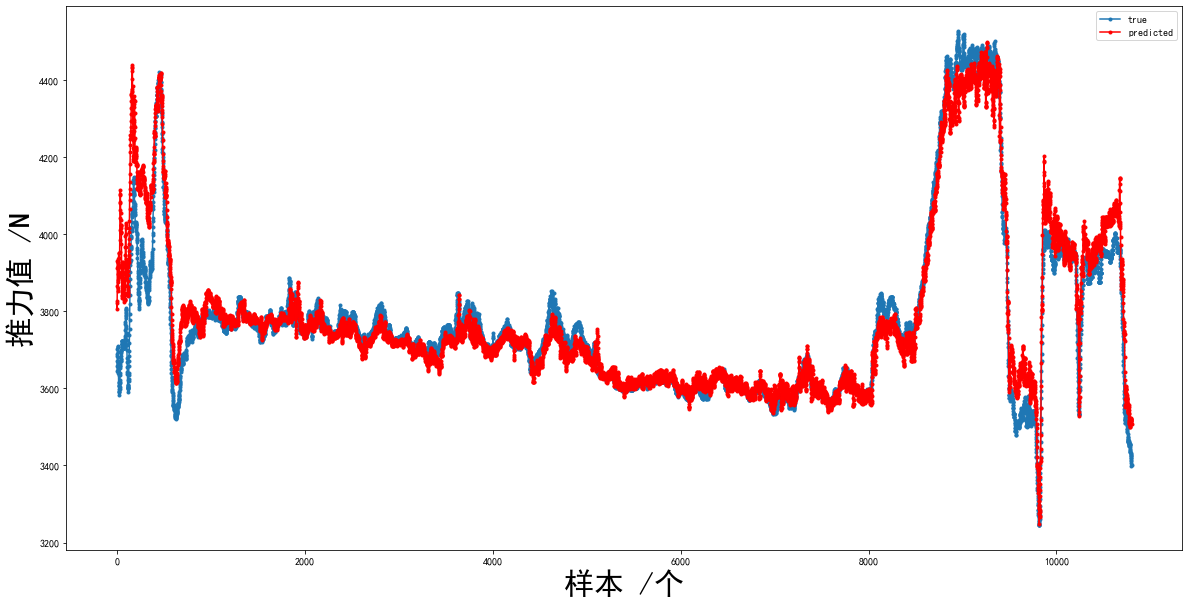

In [32]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 